# HDDM models informed with EEG and pre-trial accuracy

Imports

In [ ]:
import cmdstanpy
cmdstanpy.install_cmdstan()

In [1]:
from cmdstanpy import CmdStanModel
import os
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import json
import time
from contextlib import redirect_stdout
import seaborn as sns
# set path to CMD Stan
# set_cmdstan_path('/stan/math_HOW-TO-USE/cmdstan-ddm-7pm')
# cmdstan_path()

# set Stan globals
# os.environ['STAN_NUM_THREADS'] = "12"

/home/anna/Work/jointError_cmd_test/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define the model

In [2]:
name = 'drift_boundary_pre2_ncond_tbb' 
model_name = f'wiener_{name}_model.stan'

print(f'Processing model: {model_name}')

Processing model: wiener_drift_boundary_pre2_ncond_tbb_model.stan


## Compile the model

In [3]:
stan_file = os.path.join('../models/TBB_models/', model_name)
hddm_model = CmdStanModel(
    stan_file=stan_file, 
    cpp_options={'STAN_THREADS': True}, 
    force_compile=True
)

13:47:30 - cmdstanpy - INFO - compiling stan file /home/anna/Work/jointErrorCMD/models/TBB_models/wiener_drift_boundary_pre2_ncond_tbb_model.stan to exe file /home/anna/Work/jointErrorCMD/models/TBB_models/wiener_drift_boundary_pre2_ncond_tbb_model
13:47:50 - cmdstanpy - INFO - compiled model executable: /home/anna/Work/jointErrorCMD/models/TBB_models/wiener_drift_boundary_pre2_ncond_tbb_model


In [4]:
hddm_model.exe_info()

{'stan_version_major': '2',
 'stan_version_minor': '34',
 'stan_version_patch': '1',
 'STAN_THREADS': 'true',
 'STAN_MPI': 'false',
 'STAN_OPENCL': 'false',
 'STAN_NO_RANGE_CHECKS': 'false',
 'STAN_CPP_OPTIMS': 'false'}

## Define data file

In [5]:
data_file = os.path.join('../data/', 'stahl_spe_data_standarized.json')

### Read the data

In [6]:
with open(data_file, 'r') as file:
    data = json.load(file)

In [7]:
data_df = pd.DataFrame(
    {
        'participant_index': data['participant'],
         'rt': abs(np.array(data['y']))
    }
)

In [8]:
data_df

,participant_index,rt
0,1,0.260
1,1,0.454
2,1,0.746
3,1,0.470
4,1,0.456
...,...,...
6808,61,0.450
6809,61,0.454
6810,61,0.432
6811,61,0.414


In [9]:
with pd.option_context('display.max_rows', None,):
    display(data_df.groupby('participant_index').describe())

rt                                                     \
                   count      mean       std    min      25%    50%     75%   
participant_index                                                             
1                   97.0  0.340103  0.118813  0.160  0.24600  0.302  0.4300   
2                  101.0  0.433970  0.134579  0.152  0.34400  0.450  0.5400   
3                  131.0  0.548099  0.127617  0.292  0.46200  0.532  0.6180   
4                   88.0  0.482182  0.192124  0.130  0.35000  0.469  0.5910   
5                  109.0  0.513193  0.185107  0.204  0.39400  0.496  0.6000   
6                   72.0  0.422833  0.185801  0.114  0.24950  0.411  0.5680   
7                  146.0  0.525911  0.153645  0.226  0.42950  0.515  0.5915   
8                  117.0  0.462547  0.184979  0.108  0.33600  0.456  0.5520   
9                   87.0  0.544391  0.276230  0.112  0.29600  0.564  0.7280   
10                  69.0  0.536319  0.118473  0.168  0.47600  0.522  0.6220   
11                 150.0  0.439893  0.178316  0.138  0.33200  0.408  0.5080   
12                 117.0  0.464709  0.085466  0.252  0.40600  0.464  0.5200   
13                 109.0  0.458844  0.125013  0.140  0.38200  0.448  0.5420   
14                 127.0  0.483756  0.171757  0.132  0.37700  0.492  0.5800   
15                 112.0  0.491625  0.213652  0.130  0.32550  0.487  0.6040   
16                  77.0  0.541143  0.141487  0.314  0.45800  0.512  0.6140   
17                 110.0  0.404645  0.144208  0.132  0.28425  0.406  0.5160   
18                 123.0  0.515333  0.191682  0.204  0.38500  0.474  0.6230   
19                 121.0  0.520017  0.100761  0.304  0.45400  0.526  0.5800   
20                 121.0  0.457074  0.192522  0.142  0.33400  0.460  0.5280   
21                 135.0  0.508726  0.101814  0.268  0.43600  0.502  0.5760   
22                 287.0  0.475296  0.100563  0.298  0.40700  0.466  0.5240   
23                  77.0  0.390039  0.178674  0.102  0.26000  0.358  0.5280   
24                  54.0  0.456593  0.156834  0.106  0.39200  0.484  0.5625   
25                  72.0  0.357250  0.152129  0.102  0.20400  0.362  0.4685   
26                 120.0  0.474867  0.184135  0.158  0.32150  0.454  0.5725   
27                  95.0  0.335347  0.119615  0.114  0.23600  0.328  0.4350   
28                 111.0  0.442829  0.155601  0.172  0.32300  0.416  0.5490   
29                 114.0  0.429877  0.179960  0.160  0.27900  0.415  0.5545   
30                 325.0  0.531197  0.096484  0.342  0.46800  0.518  0.5760   
31                  96.0  0.484802  0.164719  0.180  0.37850  0.487  0.5740   
32                 103.0  0.537981  0.092186  0.380  0.48000  0.524  0.5800   
33                  93.0  0.404903  0.145606  0.138  0.28600  0.420  0.4900   
34                  85.0  0.460553  0.184163  0.132  0.26600  0.474  0.6000   
35                  72.0  0.491458  0.142900  0.154  0.41800  0.494  0.5715   
36                 104.0  0.501731  0.109378  0.252  0.42650  0.487  0.5740   
37                 126.0  0.515889  0.164011  0.166  0.42400  0.509  0.6015   
38                  99.0  0.486606  0.244861  0.118  0.34700  0.474  0.6100   
39                 117.0  0.536915  0.107687  0.332  0.45600  0.524  0.6100   
40                  58.0  0.473000  0.193052  0.188  0.28650  0.521  0.5955   
41                 134.0  0.574448  0.201097  0.274  0.44425  0.534  0.6720   
42                  94.0  0.405862  0.186851  0.112  0.26650  0.395  0.5135   
43                  84.0  0.464262  0.107087  0.292  0.37150  0.461  0.5375   
44                 120.0  0.605000  0.145290  0.298  0.50250  0.588  0.6835   
45                  92.0  0.614348  0.141712  0.326  0.50400  0.594  0.6985   
46                 112.0  0.500804  0.234126  0.138  0.31350  0.497  0.6445   
47                 118.0  0.479729  0.233488  0.140  0.34800  0.438  0.5975   
48                 139.0  0.496388  0.181659  0.166  0.39800  0.470  0.5

## Fit the model

Fit parameters

In [13]:
num_chains = 4
warmup = 5000
num_samples = 10000
thin=5
adapt_delta=0.99
random_state = 42

Define initial values

In [14]:
n_participants = data['n_participants']

min_rt = np.zeros(n_participants)
for idx, participant_idx in enumerate(np.unique(data['participant'])):
    participant_rts = data_df[data_df['participant_index'] == participant_idx]['rt'].to_numpy()
    min_rt[idx] = np.min(abs(participant_rts))

initials = []
for c in range(0, num_chains):
    chain_init = {               
        'ter_sd': np.random.uniform(.01, .2),
        'alpha_sd': np.random.uniform(.01, 1.),
        'alpha_cond_sd': np.random.uniform(.01, 1.), # <- was 0.5
        'delta_sd': np.random.uniform(.1, 3.),
        'delta_cond_sd': np.random.uniform(.1, 3.),
        
        'alpha_ne_sd': np.random.uniform(.01, .2), # <- works quite nice with .01, .2, works with .01, 1 
        'delta_ne_sd': np.random.uniform(.001, .2), # 0.2 ###########

        'alpha_ne_pre_acc_sd': np.random.uniform(.01, .2), # <- works quite nice with .01, .2, works with .01, 1 
        'delta_ne_pre_acc_sd': np.random.uniform(.001, .2), # 0.2 ###########

        'ter': np.random.uniform(0.05, .3),
        'alpha': np.random.uniform(1, 2), #0.2 ## <- does not work with < 1
        'alpha_cond': np.random.uniform(-.5, .5), # <- was -.1, .1 and works a little bit better
        'delta': np.random.uniform(-4., 4.),
        'delta_cond': np.random.uniform(-4., 4.),

        'alpha_ne': np.random.uniform(-.05, .05), # <- does not work with -0.1, 0.1
        'alpha_pre_acc': np.random.uniform(-0.1, .1), 
        'alpha_ne_pre_acc': np.random.uniform(-.05, .05), # does not work with -0.1, 0.1
        'alpha_ne_cond': np.random.uniform(-.05, .05), # <- does not work with -0.1, 0.1
        'alpha_pre_acc_cond': np.random.uniform(-0.1, .1), 
        'alpha_ne_pre_acc_cond': np.random.uniform(-.05, .05), # does not work with -0.1, 0.1

        'delta_ne': np.random.uniform(-.1, .1),
        'delta_pre_acc': np.random.uniform(-.5, .5),
        'delta_ne_pre_acc': np.random.uniform(-.1, .1),
        'delta_ne_cond': np.random.uniform(-.1, .1),
        'delta_pre_acc_cond': np.random.uniform(-.5, .5),
        'delta_ne_pre_acc_cond': np.random.uniform(-.1, .1),
        
        'participants_ter': np.random.uniform(0.05, .3, size=n_participants),
        'participants_alpha': np.random.uniform(1, 2., size=n_participants), ## <- does not work with <1
        'participants_alpha_cond': np.random.uniform(-0.5, .5, size=n_participants), # <- was -.1, .1 and works a little bit better 
        'participants_delta': np.random.uniform(-4., 4., size=n_participants),
        'participants_delta_cond': np.random.uniform(-4., 4., size=n_participants),
        
        'participants_alpha_ne': np.random.uniform(-.05, .05, size=n_participants),
        'participants_delta_ne': np.random.uniform(-.1, .1, size=n_participants), #########

        'participants_alpha_ne_pre_acc': np.random.uniform(-.05, .05, size=n_participants),
        'participants_delta_ne_pre_acc': np.random.uniform(-.05, .05, size=n_participants), #########
    }
    for p in range(0, n_participants):
        chain_init['participants_ter'][p] = np.random.uniform(0., min_rt[p]/2)

    initials.append(chain_init)

print(min_rt)

[0.16  0.152 0.292 0.13  0.204 0.114 0.226 0.108 0.112 0.168 0.138 0.252
 0.14  0.132 0.13  0.314 0.132 0.204 0.304 0.142 0.268 0.298 0.102 0.106
 0.102 0.158 0.114 0.172 0.16  0.342 0.18  0.38  0.138 0.132 0.154 0.252
 0.166 0.118 0.332 0.188 0.274 0.112 0.292 0.298 0.326 0.138 0.14  0.166
 0.114 0.108 0.15  0.334 0.208 0.204 0.112 0.222 0.12  0.328 0.284 0.234
 0.156]


Perform fit

In [ ]:
with open('jupyter_logs.txt', 'a') as f:
    with redirect_stdout(f):
        start = time.time()
        fit = hddm_model.sample(
            data=data_file,
            chains=num_chains, 
            seed=random_state,
            thin=thin,
            adapt_delta=adapt_delta,
            inits=initials, 
            iter_warmup=warmup, 
            iter_sampling=num_samples,
            parallel_chains=num_chains,
            threads_per_chain= 12,
            max_treedepth=12,
            show_progress=True,
            show_console=True,
        )
        end = time.time()

print(f'Fitting took: {end - start}')

13:48:25 - cmdstanpy - INFO - CmdStan start processing


In [ ]:
print(fit.diagnose())

In [92]:
summary_df = fit.summary()

In [93]:
summary_df.to_csv(f'test_priors2_summary.csv')

In [ ]:
# 7 - changed initials (as boundary(and main effects - the same as boundary, no sd priors || 1.23
# 6 - changed initials and main effects, and sd priors ||1.6 for delta_ne_sd
# 5 - changed initials and main effects, no sd priors || 1.10 for delta_ne_sd
# 4 - changed initials and main effects, and sd priors
# 3 - ?
# 2 - main effects, and sd priors
# 1 - changed main effects

<Axes: xlabel='iter__', ylabel='delta_ne_sd'>

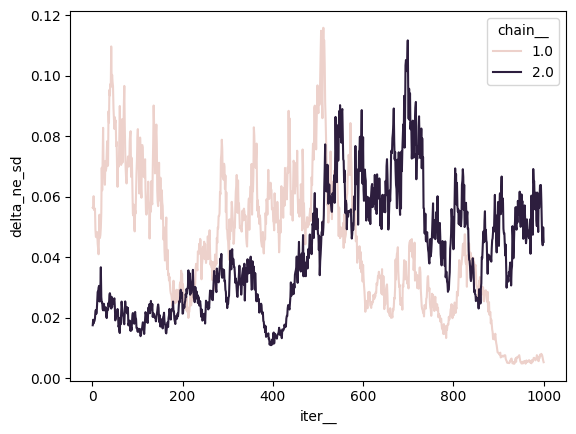

In [94]:
fit_df = fit.draws_pd()

sns.lineplot(
    data=fit_df,
    x = 'iter__',
    y = 'delta_ne_sd',
    hue='chain__'
)

Save the MCMC fit object

In [ ]:
fit.save_csvfiles(dir=f'../cmd_results/stahl/spe/new/stahl_spe_{name}_warmup-{warmup}_samples-{num_samples}_thin-{thin}-3/')